# Проект: классификация

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [28]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [29]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [30]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [31]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def get_float(value):
    if type(value) == str:
        value = value.replace(' ', '').replace('$', '').replace(',', '.')
        return float(value)

df['balance'] = df['balance'].apply(get_float)
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [32]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'].fillna(df['balance'].median(), inplace=True)
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [33]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'].loc[df['job']=='unknown'] = job_mode
df['education'].loc[df['education']=='unknown'] = education_mode

mask1 = df['job'] == job_mode
mask2 = df['education'] == education_mode
round(df['balance'][mask1 & mask2].mean(), 3)

1598.883

### Задание 6

In [35]:
df['balance'].quantile(0.25)

123.0

In [36]:
df['balance'].quantile(0.75)

1699.0

In [39]:
# удалите все выбросы для признака balance
# ваш код
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
low_bound = q1 - 1.5 * (q3-q1)
high_bound = q3 + 1.5 * (q3-q1)
print(low_bound, high_bound)
df = df[(df['balance'] >= low_bound) & (df['balance'] <= high_bound)]
df.shape[0]

-2241.0 4063.0


10105

## Часть 2:  Разведывательный анализ

### Задание 1

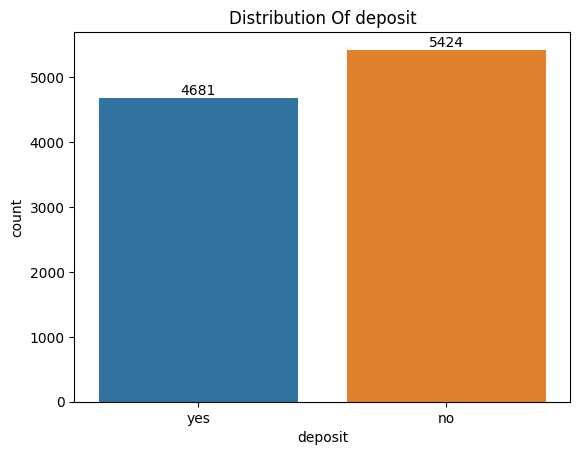

In [23]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
fig = sns.countplot(x=df['deposit'], hue=df['deposit'])
fig.set_title("Distribution Of deposit")
for container in fig.containers:
    fig.bar_label(container)
plt.show()

### Задания 2 и 3

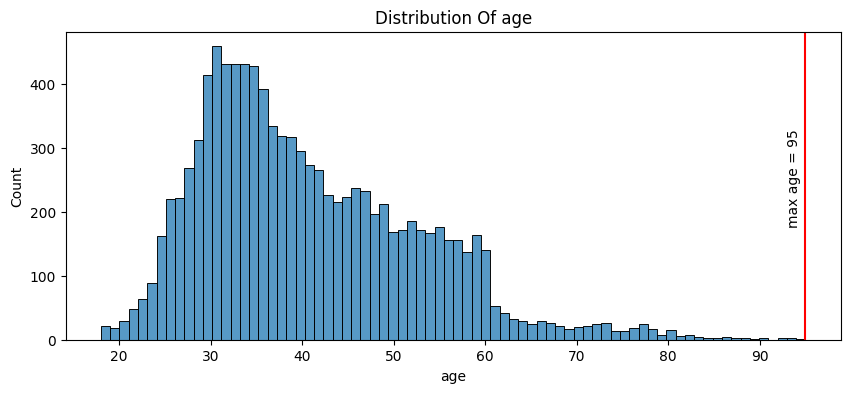

In [108]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
fig= plt.figure(figsize=(10,4))
fig = sns.histplot(df['age'], bins=df['age'].value_counts().shape[0])
fig.set_title('Distribution Of age')
fig2 = plt.axvline(df['age'].max(), color='red')
plt.text(x=df['age'].max()-2, y=180, s=f'max age = {df["age"].max()}', rotation=90)
plt.show()

Возраст большинства клиентов находится где-то между 25 и 60 годами. Распределение напоминает логнормальное. Максимальный возраст 95 лет.

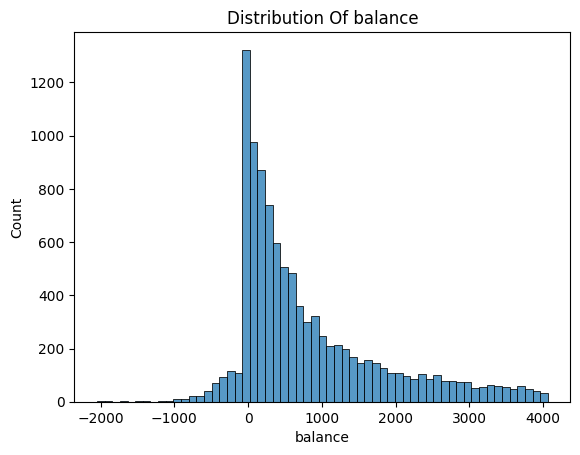

In [98]:
fig = sns.histplot(df['balance'])
fig.set_title('Distribution Of balance')
plt.show()

Основной баланс клиентов находится в районе нуля. Распределение также напоминает логнормальное или нормальное, по крайней мере в правой части. В области с отрицательным балансом график резко обрывается.

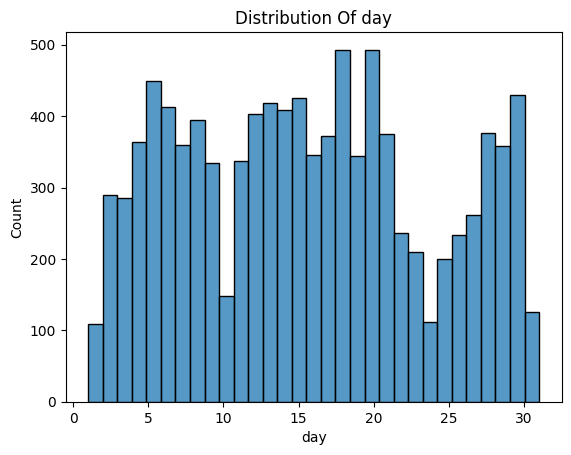

In [113]:
fig = sns.histplot(df['day'], bins=df['day'].value_counts().shape[0])
fig.set_title('Distribution Of day')
plt.show()

Переменная day вряд ли имеет много смысла в отрыве от месяца, т.к. показывает только число. Даже каких-то выводов об активности в начале, конце или середине месяца сложно сделать.

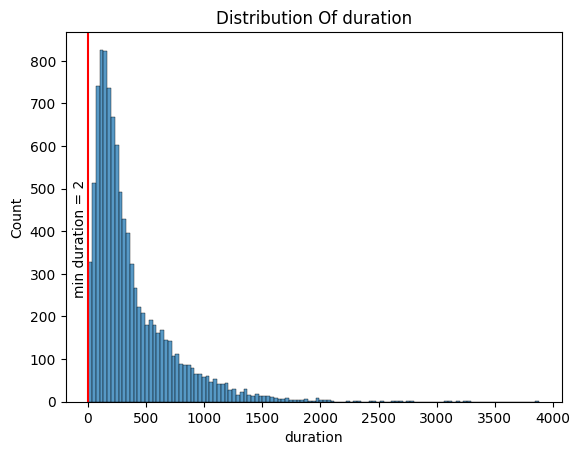

In [107]:
fig = sns.histplot(df['duration'])
fig.set_title('Distribution Of duration')
fig2 = plt.axvline(df['duration'].min(), color='red')
plt.text(x=df['duration'].min()-130, y=250, s=f'min duration = {df["duration"].min()}', rotation=90)
plt.show()

Здесь распределение очень похоже даже не на логнормальное, а на степенной закон. Минимальная длительность контакта - 2 секунды.

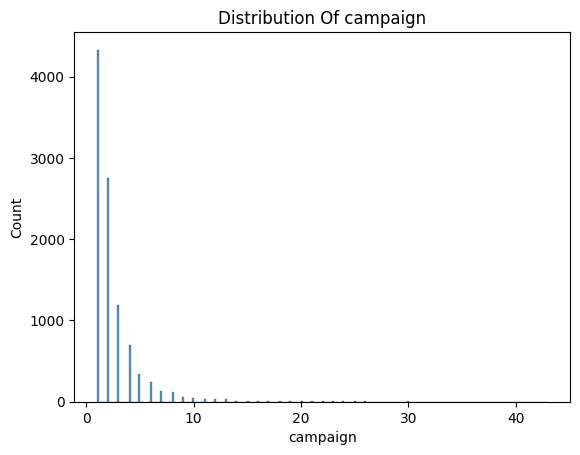

In [115]:
fig = sns.histplot(df['campaign'])
fig.set_title('Distribution Of campaign')
plt.show()

Количесвто контактов с одним клиентом тоже убывает, напоминая степенной закон или логнормальное распределение.

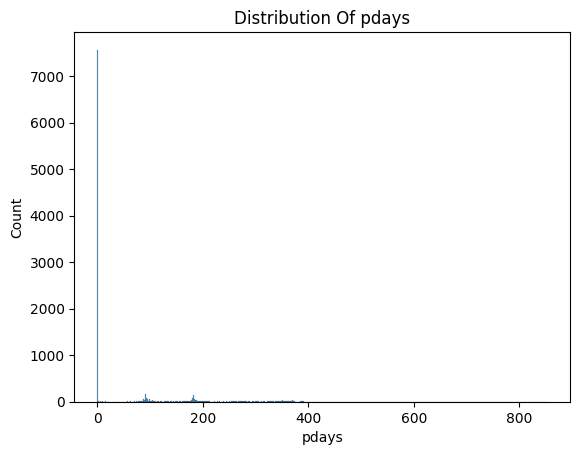

In [117]:
fig = sns.histplot(df['pdays'], bins=df['pdays'].value_counts().shape[0])
fig.set_title('Distribution Of pdays')
plt.show()

Видимо, такое большое значение в нуле связано с тем, что здесь последней кампанией считается текущая и поэтому клиенты, с которыми был контакт только что помечены 0 пропущенных дней.

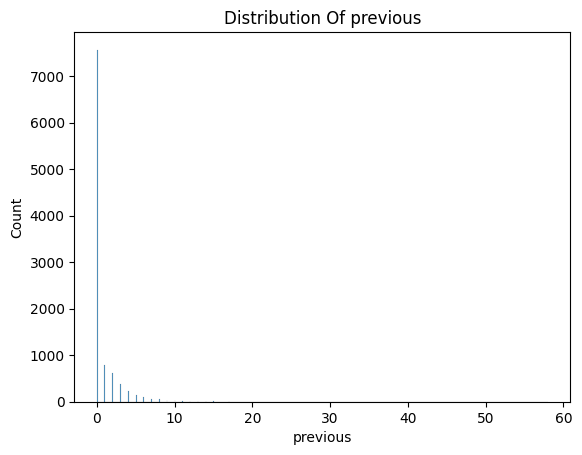

In [119]:
fig = sns.histplot(df['previous'])
fig.set_title('Distribution Of previous')
plt.show()

С большей частью клиентов вообще не было контактов во время маркетинговых кампаний.

In [109]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

: 

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

: 

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

: 

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

: 

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

: 

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

: 

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

: 

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

: 

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

: 

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

: 

### Задание 4

In [ ]:
# создайте дамми-переменные

: 

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

: 

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

: 

In [ ]:
# рассчитайте необходимые показатели

: 

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

: 

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

: 

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

: 

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

: 

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

: 

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

: 

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

: 

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

: 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

: 

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

: 